In [1]:
# 载入必要的库
import numpy as np
import tensorflow as tf
import keras

from matplotlib import pyplot as plt

from keras import Model
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, BatchNormalization, MaxPooling2D

from keras.layers import Flatten, Dropout, Dense, Input, concatenate, add, Activation
from tensorflow.keras.applications import VGG16

Using TensorFlow backend.


## 读取数据 

###  构建数据生成器

In [2]:
IMSIZE=224

train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    '/course7/data/data_res/train',
    target_size=(IMSIZE, IMSIZE),
    batch_size=100,
    class_mode='categorical')

validation_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    '/course7/data/data_res/validation',
    target_size=(IMSIZE, IMSIZE),
    batch_size=100,
    class_mode='categorical')

Found 1612 images belonging to 3 classes.
Found 355 images belonging to 3 classes.


###  可视化

<Figure size 432x288 with 0 Axes>

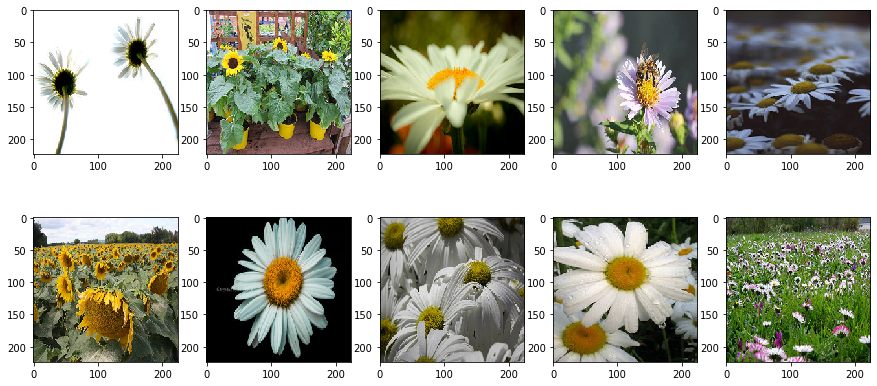

In [3]:
plt.figure()
fig,ax = plt.subplots(2,5)
fig.set_figheight(7)
fig.set_figwidth(15)
ax=ax.flatten()
X,Y=next(train_generator)
for i in range(10): ax[i].imshow(X[i,:,:,:])

### 构建ResNet模型 

### 模型建立 

In [4]:
IMSIZE = 224
input_shape = (IMSIZE, IMSIZE, 3)
input_layer = Input(input_shape)

x = Conv2D(64, (7,7), padding='same', strides=(2,2), activation='relu')(input_layer)
x = BatchNormalization()(x)
# 一个卷积层加一个batch normalization
x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
x0 = x

# 一个block
x = Conv2D(64, (1,1), padding='same', strides=(1,1), activation='relu')(x)
x = BatchNormalization()(x)
# 一个卷积层加一个batch normalization
x = Conv2D(64, (3,3), padding='same', strides=(1,1), activation='relu')(x)
x = BatchNormalization()(x)
# 一个卷积层加一个batch normalization
x = Conv2D(256, (1,1), padding='same', strides=(1,1), activation=None)(x)
x = BatchNormalization()(x)
# 一个卷积层加一个batch normalization

# 下面两步为了把输入64通道的数据转换为256个通道，用来让x0和x维数相同，可以进行加法计算，文章中虚线得的部分
x0 = Conv2D(256,(1,1),padding='same',strides=(1,1),activation='relu')(x0)
x0 = BatchNormalization()(x0)
x = add([x,x0])# add把输入的x和经过一个block之后输出的结果加在一起
x = Activation('relu')(x)#求和之后的结果再做一次relu
x0 = x # 把输入存到一个另外的变量中

model = Model(inputs=input_layer,outputs=x)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 112, 112, 64) 256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 56, 56, 64)   0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [5]:
# 添加全连接层
x = model.output
x = Flatten()(x)
predictions = Dense(3,activation='softmax')(x)
model_res = Model(inputs=model.input,outputs=predictions)
model_res.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 112, 112, 64) 256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 56, 56, 64)   0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

### 模型编译及拟合 

In [6]:
model_res.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.0001),metrics=['accuracy'])
model_res.fit(train_generator,epochs=3,validation_data=validation_generator)

Epoch 1/3
17/17 [==============================] - 22s 1s/step - loss: 8.2935 - accuracy: 0.5893 - val_loss: 0.7312 - val_accuracy: 0.7549
Epoch 2/3
17/17 [==============================] - 11s 666ms/step - loss: 2.0464 - accuracy: 0.8077 - val_loss: 1.0258 - val_accuracy: 0.5099
Epoch 3/3
17/17 [==============================] - 13s 757ms/step - loss: 0.6235 - accuracy: 0.8803 - val_loss: 0.9553 - val_accuracy: 0.6704
